## Classifier

In [ ]:
#@title Imports
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


In [ ]:
#@title MNIST Dataset Loading
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.96MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 158kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.49MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.43MB/s]


In [ ]:
#@title DataLoaders
train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

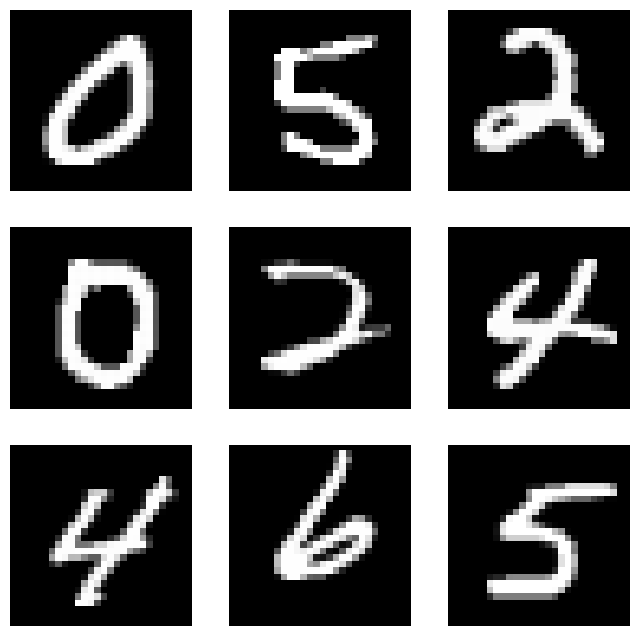

In [ ]:
#@title Visualize Random Training Samples
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
#@title Neural Network Class Definition (Classifier)
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_stack = nn.Sequential(
            nn.Linear(28*28, 32),
            nn.ReLU(),
            nn.Linear(32,64),
            nn.ReLU(),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_stack(x)
        return logits

model = NeuralNetwork()

In [ ]:
#@title Model, Loss Function, Optimizer

# Model
model = NeuralNetwork()

# Learning rate
learning_rate = 1e-3

# Loss Function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
#@title Training Loop Function
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
#@title Test / Evaluation Loop Function
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
#@title Training the Classifier
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")


Epoch 1
-------------------------------
loss: 2.308837  [    0/60000]
loss: 2.303866  [ 6400/60000]
loss: 2.295195  [12800/60000]
loss: 2.285060  [19200/60000]
loss: 2.287858  [25600/60000]
loss: 2.295852  [32000/60000]
loss: 2.306234  [38400/60000]
loss: 2.298536  [44800/60000]
loss: 2.277130  [51200/60000]
loss: 2.270961  [57600/60000]
Test Error: 
 Accuracy: 20.6%, Avg loss: 2.279324 

Epoch 2
-------------------------------
loss: 2.281586  [    0/60000]
loss: 2.276154  [ 6400/60000]
loss: 2.270275  [12800/60000]
loss: 2.245338  [19200/60000]
loss: 2.257625  [25600/60000]
loss: 2.266347  [32000/60000]
loss: 2.263054  [38400/60000]
loss: 2.268266  [44800/60000]
loss: 2.234825  [51200/60000]
loss: 2.223631  [57600/60000]
Test Error: 
 Accuracy: 31.2%, Avg loss: 2.232913 

Epoch 3
-------------------------------
loss: 2.236371  [    0/60000]
loss: 2.231062  [ 6400/60000]
loss: 2.225266  [12800/60000]
loss: 2.182132  [19200/60000]
loss: 2.203815  [25600/60000]
loss: 2.217403  [32000/600

In [ ]:
#@title Inspect Model Parameters
params = list(model.parameters())
print("Number of learnable parameters' sets: " , len(params))
for i in params:
  print(i.size())


Number of learnable parameters' sets:  6
torch.Size([32, 784])
torch.Size([32])
torch.Size([64, 32])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])


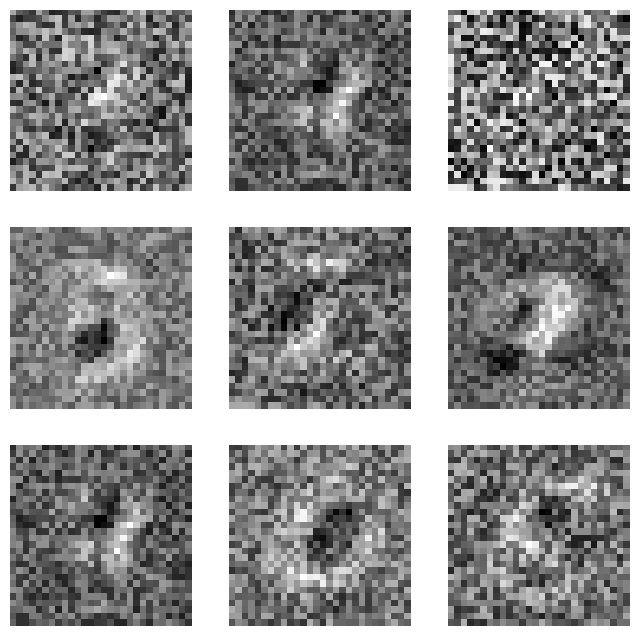

In [ ]:
#@title Visualize First Layer Weights
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
input_height=28
input_width=28
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(params[0].size(0), size=(1,)).item()
    img = params[0][sample_idx,:]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.detach().view(input_height,input_width), cmap="gray")
plt.show()

## Autoencoder

In [ ]:
#@title Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [ ]:
#@title Device Configuration


# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#@title Autoencoder Class Definition

# Define the autoencoder architecture separately in order to easily retrieve latent representations
class Autoencoder(nn.Module):
    def __init__(self, input_size, latent_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, latent_size)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 128),
            nn.ReLU(),
            nn.Linear(128, input_size),
            nn.Sigmoid()  # Sigmoid activation for output to be between 0 and 1
        )

    # Define forward pass as an encoding followed by decoding
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
#@title Autoencoder Hyperparameters

# Hyperparameters
input_size = 784  #  28px x 28px = 784
latent_size = 32
batch_size = 64
learning_rate = 0.001
num_epochs = 20

In [ ]:
#@title MNIST Loading for Autoencoder

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

In [ ]:
#@title Autoencoder Initialization

# Initialize the autoencoder
model = Autoencoder(input_size, latent_size).to(device)

In [ ]:
#@title Autoencoder Loss and Optimizer

# Loss Funtion
criterion = nn.MSELoss() # MSE is the standard reconstruction-oriented loss

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
#@title Autoencoder Training Loop

# Training the autoencoder
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.view(img.size(0), -1).to(device)

        # Forward pass
        output = model(img)

        # Compute the loss
        loss = criterion(output, img)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the loss for every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch [1/20], Loss: 0.0181
Epoch [2/20], Loss: 0.0142
Epoch [3/20], Loss: 0.0102
Epoch [4/20], Loss: 0.0095
Epoch [5/20], Loss: 0.0093
Epoch [6/20], Loss: 0.0077
Epoch [7/20], Loss: 0.0075
Epoch [8/20], Loss: 0.0076
Epoch [9/20], Loss: 0.0075
Epoch [10/20], Loss: 0.0063
Epoch [11/20], Loss: 0.0073
Epoch [12/20], Loss: 0.0070
Epoch [13/20], Loss: 0.0063
Epoch [14/20], Loss: 0.0062
Epoch [15/20], Loss: 0.0060
Epoch [16/20], Loss: 0.0060
Epoch [17/20], Loss: 0.0071
Epoch [18/20], Loss: 0.0056
Epoch [19/20], Loss: 0.0071
Epoch [20/20], Loss: 0.0053


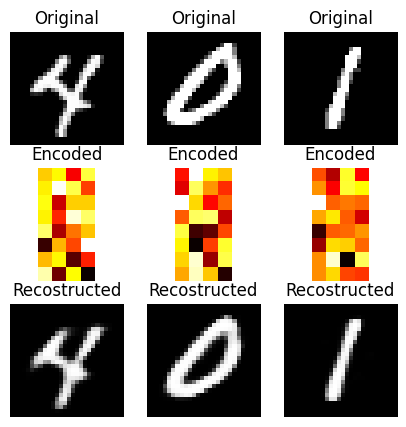

In [ ]:
#@title Autoencoder Encoding & Reconstruction Visualization

# Test the trained autoencoder
break_iter=1
with torch.no_grad():
    for data in train_loader:
        img, labels = data
        img = img.view(img.size(0), -1).to(device)

        # Encode the input images
        encoded_imgs = model.encoder(img)
        rec_imgs =model.decoder(encoded_imgs)

        # Visualize the original, encoded and reconstructed images
        plt.figure(figsize=(5, 5))
        for i in range(3):
            # Original images
            plt.subplot(3, 3, i + 1)
            plt.imshow(img[i].cpu().numpy().reshape(28, 28), cmap='gray')
            plt.title('Original')
            plt.axis('off')

            # Latent representation
            plt.subplot(3, 3, i + 4)
            plt.imshow(rec_imgs[i].cpu().numpy().reshape(28, 28), cmap='gray')
            plt.title('Recostructed')
            plt.axis('off')

            # Latent representation
            plt.subplot(3, 3, i + 4)
            plt.imshow(encoded_imgs[i].cpu().numpy().reshape(8, 4), cmap='hot')  # Displaying latent vector as colors
            plt.title('Encoded')
            plt.axis('off')

            # Recostructed images
            plt.subplot(3, 3, i + 7)
            plt.imshow(rec_imgs[i].cpu().numpy().reshape(28, 28), cmap='gray')
            plt.title('Recostructed')
            plt.axis('off')


        plt.show()
        break  # Break after the first batch for brevity